<a href="https://colab.research.google.com/github/ryangithubaccount/DSA2000/blob/main/discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
#@title Hyperparameters

class Resnet_Hyperparams():
    def __init__(self, train_loader):
        self.iterations = len(train_loader)
        self.epochs =  64000
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 0.0001
        self.milestones = [32000,
                           48000]
        self.lr_multiplier = 0.1

In [ ]:
#@title Resnet Definition

class Block(nn.Module):
    def __init__(self, out_channels, stride=1):
        super().__init__()
        self.out_channels = out_channels
        self.kernel_size = 3
        self.padding = 1
        self.stride = stride

        in_channels1 = out_channels
        in_channels2 = out_channels
        if stride != 1:
            in_channels1 = in_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels=in_channels1, out_channels=out_channels, padding=self.padding,
                               kernel_size=self.kernel_size, stride=stride, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels2, out_channels=out_channels, padding=self.padding,
                               kernel_size=self.kernel_size, stride=1, bias=False)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def skip_connection(self, F, X):
        '''
        F (tensor): block input
        x (tensor): activations of the block before relu

        If dimensions of input x are greater than activations then downsample and
        zero padding dimension 1 as described by option A in paper.
        '''
        X = X.to(torch.float32)
        F = F.to(torch.float32)
        if X.shape == F.shape:
            return torch.add(F, X)
        else:
            avgpool = nn.AvgPool2d(1, stride=2)
            X = avgpool(X)
            X = nn.functional.pad(X, (0, 0, 0, 0, 0, F.shape[1] - X.shape[1]), value=0)
            return torch.add(F, X)

    def forward(self, X):
        F = self.conv1(X)
        F = self.batchnorm(self.conv2(self.relu(self.batchnorm((F)))))
        F = self.skip_connection(F, X)
        out = self.relu(F)
        return out


class Resnet(nn.Module):
    def __init__(self, N, stride=2):
        super().__init__()

        # Input
        self.conv = nn.Conv2d ( 1, 16, kernel_size=3, stride=1, padding=1, bias=False )
        self.bn = nn.BatchNorm2d ( 16, track_running_stats=True )
        self.relu = nn.ReLU()

        self.stack1 = nn.ModuleList([Block(16) for _ in range(N)])

        self.stack2 = nn.ModuleList([Block(32, stride=stride)] + [Block(32) for _ in range(N - 1)])

        self.stack3 = nn.ModuleList([Block(64, stride=stride)] + [Block(64) for _ in range(N - 1)])

        self.upsample1 = nn.Sequential(nn.Upsample(scale_factor=2),
                                        nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False))

        self.upsample2 = nn.Sequential(nn.Upsample(scale_factor=2),
                                        nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=False))

        self.final_conv = nn.Conv2d(16, 2, kernel_size=3, padding=1, bias=False)

        # init weights in the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()


    def forward(self, X):
        out = self.relu(self.bn(self.conv(X)))

        for layer in self.stack1:
            out = layer.forward(out)

        for layer in self.stack2:
            out = layer.forward(out)

        for layer in self.stack3:
            out = layer.forward(out)

        # out = self.reshape_layer(out)
        out = self.upsample1(out)
        out = self.upsample2(out)
        out = self.final_conv(out)

        return out

In [ ]:
#@title Loader Definition

def load_data(train_dataset, labels,
                      batch_size):

    tensor_x = torch.Tensor(train_dataset) # transform to torch tensor
    tensor_y = torch.Tensor(labels)

    train_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    return train_dataset, train_loader

In [ ]:
#@title Initialize Clean+RFI Data
batch_size = 128

c0_data = np.load('/content/drive/MyDrive/CS 101 Group/noRFI/24by100.npy')[:1000]
size = np.shape(c0_data)[0]
c1_data = np.load('/content/drive/MyDrive/CS 101 Group/yesRFI/24by100.npy')[:1000]
indices = np.random.randint(0, np.shape(c1_data)[0], 2 * size)
c2_data = c1_data[indices[:size]]
c1_data = c1_data[indices[size:]]


c0_labels = np.zeros((size, 1))
c1_labels = np.ones((size, 1))
c2_labels = np.ones((size, 1))

c0_train_dataset = c0_data[:int(size * 0.7)]
c0_validation_dataset = c0_data[int(size * 0.7): int(size * 0.85)]
c0_test_dataset = c0_data[int(size * 0.85):]

c1_train_dataset = c1_data[:int(size * 0.7)]
c1_validation_dataset = c1_data[int(size * 0.7): int(size * 0.85)]
c1_test_dataset = c1_data[int(size * 0.85):]

c2_train_dataset = c2_data[:int(size * 0.7)]
c2_validation_dataset = c2_data[int(size * 0.7): int(size * 0.85)]
c2_test_dataset = c2_data[int(size * 0.85):]

c0_train_labels = c0_labels[:int(size * 0.7)]
c0_validation_labels = c0_labels[int(size * 0.7): int(size * 0.85)]
c0_test_labels = c0_labels[int(size * 0.85):]

c1_train_labels = c1_labels[:int(size * 0.7)]
c1_validation_labels = c1_labels[int(size * 0.7): int(size * 0.85)]
c1_test_labels = c1_labels[int(size * 0.85):]

c2_train_labels = c2_labels[:int(size * 0.7)]
c2_validation_labels = c2_labels[int(size * 0.7): int(size * 0.85)]
c2_test_labels = c2_labels[int(size * 0.85):]

c0_train_dataset = (c0_train_dataset - np.mean(c0_train_dataset)) / np.std(c0_train_dataset)
c0_validation_dataset = (c0_validation_dataset - np.mean(c0_validation_dataset)) / np.std(c0_validation_dataset)
c0_test_dataset = (c0_test_dataset - np.mean(c0_test_dataset)) / np.std(c0_test_dataset)

c1_train_dataset = (c1_train_dataset - np.mean(c1_train_dataset)) / np.std(c1_train_dataset)
c1_validation_dataset = (c1_validation_dataset - np.mean(c1_validation_dataset)) / np.std(c1_validation_dataset)
c1_test_dataset = (c1_test_dataset - np.mean(c1_test_dataset)) / np.std(c1_test_dataset)

c2_train_dataset = (c2_train_dataset - np.mean(c2_train_dataset)) / np.std(c2_train_dataset)
c2_validation_dataset = (c2_validation_dataset - np.mean(c2_validation_dataset)) / np.std(c2_validation_dataset)
c2_test_dataset = (c2_test_dataset - np.mean(c2_test_dataset)) / np.std(c2_test_dataset)

_, c0_train_loader = load_data(c0_train_dataset, c0_train_labels, batch_size)
_, c0_validation_loader = load_data(c0_validation_dataset, c0_validation_labels, np.shape(c0_validation_dataset)[0])
_, c0_test_loader = load_data(c0_test_dataset, c0_test_labels, np.shape(c0_test_dataset)[0])

_, c1_train_loader = load_data(c1_train_dataset, c1_train_labels, batch_size)
_, c1_validation_loader = load_data(c1_validation_dataset, c1_validation_labels, np.shape(c1_validation_dataset)[0])
_, c1_test_loader = load_data(c1_test_dataset, c1_test_labels, np.shape(c1_test_dataset)[0])

_, c2_train_loader = load_data(c2_train_dataset, c2_train_labels, batch_size)
_, c2_validation_loader = load_data(c2_validation_dataset, c2_validation_labels, np.shape(c2_validation_dataset)[0])
_, c2_test_loader = load_data(c2_test_dataset, c2_test_labels, np.shape(c2_test_dataset)[0])

In [ ]:
#@title Load Segmentor

def load_segmentor():
  segmentor = torch.load('/content/drive/MyDrive/CS 101 Group/discriminator/last_week_lambda0.25_segmentor')
  # , map_location=torch.device('cpu')

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  segmentor.to(device)
  print(device)
  return segmentor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
segmentor = load_segmentor()

cuda:0


In [ ]:
#@title Discriminator Definition
class Block(nn.Module):
    def __init__(self, out_channels, stride=1):
        super().__init__()
        self.out_channels = out_channels
        self.kernel_size = 3
        self.padding = 1
        self.stride = stride

        in_channels1 = out_channels
        in_channels2 = out_channels
        if stride != 1:
            in_channels1 = in_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels=in_channels1, out_channels=out_channels, padding=self.padding,
                               kernel_size=self.kernel_size, stride=stride, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels2, out_channels=out_channels, padding=self.padding,
                               kernel_size=self.kernel_size, stride=1, bias=False)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def skip_connection(self, F, X):
        '''
        F (tensor): block input
        x (tensor): activations of the block before relu

        If dimensions of input x are greater than activations then downsample and
        zero padding dimension 1 as described by option A in paper.
        '''
        X = X.to(torch.float32)
        F = F.to(torch.float32)
        if X.shape == F.shape:
            return torch.add(F, X)
        else:
            avgpool = nn.AvgPool2d(1, stride=2)
            X = avgpool(X)
            X = nn.functional.pad(X, (0, 0, 0, 0, 0, F.shape[1] - X.shape[1]), value=0)
            return torch.add(F, X)

    def forward(self, X):
        F = self.conv1(X)
        F = self.batchnorm(self.conv2(self.relu(self.batchnorm((F)))))
        F = self.skip_connection(F, X)
        out = self.relu(F)
        return out

class Discriminator(nn.Module):
    def __init__(self, N, stride=2):
        super().__init__()

        # Input
        self.initial_downsample = nn.Sequential(nn.Conv2d ( 1, 4, kernel_size=3, stride=2, padding=1, bias=False ),
        nn.BatchNorm2d (4),
        nn.LeakyReLU(),
        )

        self.stack1 = nn.ModuleList([Block(4) for _ in range(N)])

        self.stack2 = nn.ModuleList([Block(8, stride=stride)] + [Block(8) for _ in range(N - 1)])

        self.stack3 = nn.ModuleList([Block(16, stride=stride)] + [Block(16) for _ in range(N - 1)])

        self.stack4 = nn.ModuleList([Block(32, stride=stride)] + [Block(32) for _ in range(N - 1)])

        self.linear = nn.Linear(448, 1)
        self.sigmoid = nn.Sigmoid()

        # init weights in the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()


    def forward(self, X):
        out = self.initial_downsample(X)

        for layer in self.stack1:
            out = layer.forward(out)

        for layer in self.stack2:
            out = layer.forward(out)

        for layer in self.stack3:
            out = layer.forward(out)

        for layer in self.stack4:
            out = layer.forward(out)

        out = out.view(out.size(0), -1)

        out = self.linear(out)

        out = self.sigmoid(out)

        return out

In [ ]:
#@title Train

def train(l, segmentor, discriminator, epochs, c0_loader, c1_loader, c2_loader, weight_criterion, category_criterion, segmentor_optimizer, discriminator_optimizer, RESULTS_PATH, scheduler=None, MODEL_PATH=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f' Using {device}')
    discriminator.to(device)
    segmentor.to(device)
    col_names = ['epoch', 'train_loss']
    discriminator_results_df = pd.DataFrame(columns=col_names).set_index('epoch')
    col_names = ['epoch', 'train_loss', 'category_loss', 'patch_loss']
    segmentor_results_df = pd.DataFrame(columns=col_names).set_index('epoch')

    for epoch in range(int(epochs)):
        segmentor.train()
        discriminator.train()

        segmentor_total_loss = []
        segmentor_weight_loss = []
        segmentor_category_loss = []
        discriminator_total_loss = []

        for c0_data, c1_data in zip(c0_loader, c1_loader):
            c0_x, c0_y = c0_data
            c1_x, c1_y = c1_data
            c0_x, c0_y = c0_x.to(device), c0_y.to(device)
            c1_x, c1_y = c1_x.to(device), c1_y.to(device)

            discriminator_optimizer.zero_grad()

            # Train discriminator
            noise = torch.randn(c1_x.size()).to(device)
            mask = segmentor(c1_x)[:, 0:1].to(device)
            mask = nn.functional.gumbel_softmax(mask, hard=True, dim=1, tau=1)
            c1_prediction = discriminator(mask * noise + (1 - mask) * c1_x).to(device)
            c0_prediction = discriminator(mask * noise + (1 - mask) * c0_x).to(device)
            # print(c1_prediction)
            # print(c0_prediction)
            discriminator_loss = category_criterion(c0_prediction, c0_y) + category_criterion(c1_prediction, c1_y)
            discriminator_loss.backward()
            discriminator_optimizer.step()

            discriminator_total_loss.append ( discriminator_loss.item() )

        if epoch > 1:
          for c0_data, c1_data, c2_data in zip(c0_loader, c1_loader, c2_loader):
              c0_x, c0_y = c0_data
              c1_x, c1_y = c1_data
              c2_x, c2_y = c2_data
              c0_x, c0_y = c0_x.to(device), c0_y.to(device)
              c1_x, c1_y = c1_x.to(device), c1_y.to(device)
              c2_x, c2_y = c2_x.to(device), c2_y.to(device)
              segmentor_optimizer.zero_grad()

              # Train segmentor on c1
              noise = torch.randn(c1_x.size()).to(device)

              mask1 = segmentor(c1_x).to(device)

              mask2 = segmentor(c2_x).to(device)

              c1_weight_loss = weight_criterion(mask1[:, 0:1], l) + weight_criterion(mask2[:, 0:1], l)

              mask1 = nn.functional.gumbel_softmax(mask1, hard=True, dim=1, tau=1)[:, 0:1].to(device)
              c1_prediction = discriminator(mask1 * noise + (1 - mask1) * c1_x).to(device)

              # Train segmentor on c1
              mask2 = nn.functional.gumbel_softmax(mask2, hard=True, dim=1, tau=1)[:, 0:1].to(device)
              c2_prediction = discriminator(mask2 * noise + (1 - mask2) * c2_x).to(device)

              c1_category_loss = category_criterion(c1_prediction, c0_y) + category_criterion(c2_prediction, c0_y)
              c1_loss = c1_weight_loss + c1_category_loss

              c1_loss.backward()
              segmentor_optimizer.step()

              segmentor_weight_loss.append ( c1_weight_loss.item() )
              segmentor_category_loss.append( c1_category_loss.item() )
              segmentor_total_loss.append ( c1_loss.item() )

        if scheduler != None:
            scheduler.step()

        segmentor_train_loss = 'Not Started'
        segmentor_categorization_loss = 'Not Started'
        segmentor_patch_loss = 'Not Started'
        if segmentor_total_loss:
          segmentor_train_loss = np.mean(segmentor_total_loss)
          segmentor_categorization_loss = np.mean(segmentor_category_loss)
          segmentor_patch_loss = np.mean(segmentor_weight_loss)
        segmentor_results_df.loc[epoch] = [segmentor_train_loss, segmentor_categorization_loss, segmentor_patch_loss]
        segmentor_results_df.to_csv ( RESULTS_PATH + '_segmentor.csv' )

        discriminator_train_loss = np.mean(discriminator_total_loss)
        discriminator_results_df.loc[epoch] = [discriminator_train_loss]
        discriminator_results_df.to_csv ( RESULTS_PATH + '_discriminator.csv' )

        print(f'epoch: {epoch+1} segmentor_train_loss: {segmentor_train_loss} discriminator_train_loss: {discriminator_train_loss}')

    torch.save(segmentor, MODEL_PATH + '_segmentor')
    torch.save(discriminator, MODEL_PATH + '_discriminator')
    print('Finished Training')

In [ ]:
#@title Losses

# def weight_loss(mask, l):
#   squared_diff = torch.square(0.1 * torch.numel(mask) - torch.sum(mask))
#   return squared_diff / torch.numel(mask) / 250

def weight_loss(mask, l):
  return l * torch.sum(torch.sigmoid(mask)) / torch.numel(mask)

In [ ]:
#@title Pretrain Functions

DEBUG=False

def f1_score ( threshold, y_pred, y_true ):
    bc_pred = (y_pred > threshold).astype(int)
    tp = np.sum(np.logical_and(bc_pred == 1, y_true == 1))
    fp = np.sum(bc_pred == 1) - tp
    fn = np.sum(np.logical_and(bc_pred == 0, y_true == 1))

    precision = 0
    if tp != 0:
      precision = tp / (tp + fp)
    recall = 0
    if tp != 0:
      recall = tp / (tp + fn)
    f1 = 0
    if precision != 0 and recall != 0:
      f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def inference(model, data_loader, device):
    flag = False
    y_true = None
    y_pred = None
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if flag:
              y_true = np.concatenate((y_true, labels.cpu()))
              y_pred = np.concatenate((y_pred, outputs.cpu()))
            else:
              y_true = np.array(labels.cpu())
              y_pred = np.array(outputs.cpu())
              flag = True
    return y_pred, y_true

def evaluate ( threshold, model, data_loader, device ):
    '''
    Calculate the classification error in (%)
    '''
    y_pred, y_true = inference(model, data_loader, device)
    return f1_score(threshold, y_pred, y_true)

def run(model, epochs, train_loader, criterion, optimizer, RESULTS_PATH, validation_loader=None, scheduler=None, MODEL_PATH=None, VAL_PATH=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f' Using {device}')
    model.to(device)
    col_names = ['epoch', 'train_loss', 'precision_train', 'recall_train', 'f1_score_train', 'precision_validation', 'recall_validation', 'f1_score_validation']
    results_df = pd.DataFrame(columns=col_names).set_index('epoch')

    best_validation_f1 = 0
    for epoch in range(int(epochs)):
        model.train()

        total_loss = []

        for i, data in enumerate(train_loader, 0):
            x, y = data
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            prediction = model(x).to(device)
            loss = criterion(prediction, y)
            # loss.requires_grad= True
            loss.backward()
            optimizer.step()

            total_loss.append ( loss.item() )
            if i % 50 == 49:
                if DEBUG:
                    print(f'{epoch +1} \t{i+1} \t{np.mean(total_loss)}' )

        if scheduler != None:
            scheduler.step()
        train_loss = np.mean(total_loss)
        precision_train, recall_train, f1_score_train = evaluate(0.5, model, train_loader, device)
        precision_validation, recall_validation, f1_score_validation = (0, 0, 0)
        if validation_loader != None:
          precision_validation, recall_validation, f1_score_validation = evaluate(0.5, model, validation_loader, device)
        if f1_score_validation > best_validation_f1:
          best_validation_f1 = f1_score_validation
          torch.save(model, VAL_PATH)
        results_df.loc[epoch] = [train_loss, precision_train, recall_train, f1_score_train, precision_validation, recall_validation, f1_score_validation]
        results_df.to_csv ( RESULTS_PATH )
        print(f'epoch: {epoch+1} f1_train: {f1_score_train} f1_validation:{f1_score_validation} train_loss: {train_loss}')

    torch.save(model, MODEL_PATH)
    print('Finished Training')


In [ ]:
#@title PreTrain Segmentor
batch_size = 128

data = np.load('/content/drive/MyDrive/CS 101 Group/simul_data_with_sources.npy')
labels = np.load('/content/drive/MyDrive/CS 101 Group/simul_labels_with_sources.npy')
converse_labels = 1 - labels
labels = np.concatenate((labels, converse_labels), axis=1)
size = np.shape(data)[0]

train_dataset = data[:int(size * 0.7)]
train_labels = labels[:int(size * 0.7)]
validation_dataset = data[int(size * 0.7): int(size * 0.85)]
validation_labels = labels[int(size * 0.7): int(size * 0.85)]
test_dataset = data[int(size * 0.85):]
test_labels = labels[int(size * 0.85):]

train_dataset = (train_dataset - np.mean(train_dataset)) / np.std(train_dataset)
validation_dataset = (validation_dataset - np.mean(validation_dataset)) / np.std(validation_dataset)
test_dataset = (test_dataset - np.mean(test_dataset)) / np.std(test_dataset)

_, train_loader = load_data(train_dataset, train_labels, batch_size)
_, validation_loader = load_data(validation_dataset, validation_labels, np.shape(validation_dataset)[0])
_, test_loader = load_data(test_dataset, test_labels, np.shape(test_dataset)[0])

segmentor = Resnet(5, stride=2)

criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()

params = Resnet_Hyperparams ( train_loader )
params.lr=0.001
params.epochs=5
params.milestones[0]=int(params.epochs*1/2)
params.milestones[1]=int(np.ceil(params.epochs*3/4))
params.weight_decay = 5e-4

optimizer = torch.optim.Adam(params=segmentor.parameters(), lr=params.lr)

results_file = '/content/drive/MyDrive/CS 101 Group/discriminator/pretrain5.csv'
model_file = '/content/drive/MyDrive/CS 101 Group/discriminator/pretrain5'
val_file = '/content/drive/MyDrive/CS 101 Group/discriminator/pretrain5_val'

run(segmentor, params.epochs, train_loader, criterion,
          optimizer, results_file, MODEL_PATH=model_file, VAL_PATH=val_file, validation_loader=validation_loader)

 Using cuda:0


KeyboardInterrupt: ignored

In [ ]:
#@title Train Model
# for num in range(1, 50, 4):
segmentor = load_segmentor()
discriminator = Discriminator(5, stride=2)

weight_criterion = weight_loss
category_criterion = nn.BCELoss()
# criterion = nn.BCELoss()

params = Resnet_Hyperparams ( c1_train_loader )
params.lr=0.001
params.epochs=30

discriminator_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=params.lr)
segmentor_optimizer = torch.optim.Adam(params=segmentor.parameters(), lr=params.lr)

results_file = f'/content/drive/MyDrive/CS 101 Group/discriminator/last_week_lambda0.25'
model_file = f'/content/drive/MyDrive/CS 101 Group/discriminator/last_week_lambda0.25'

# torch.autograd.set_detect_anomaly(True)
train(1/4, segmentor, discriminator, params.epochs, c0_train_loader, c1_train_loader, c2_train_loader, weight_criterion, category_criterion,
          segmentor_optimizer, discriminator_optimizer, results_file, MODEL_PATH=model_file)

cuda:0
 Using cuda:0
epoch: 1 segmentor_train_loss: Not Started discriminator_train_loss: 2.6273720264434814
epoch: 2 segmentor_train_loss: Not Started discriminator_train_loss: 1.8614609042803447
epoch: 3 segmentor_train_loss: 2.169127941131592 discriminator_train_loss: 1.7094565828641255
epoch: 4 segmentor_train_loss: 1.3162113825480144 discriminator_train_loss: 1.604446291923523
epoch: 5 segmentor_train_loss: 1.444111963113149 discriminator_train_loss: 1.5442730784416199
epoch: 6 segmentor_train_loss: 1.4959511756896973 discriminator_train_loss: 1.5101930896441143
epoch: 7 segmentor_train_loss: 1.6920516689618428 discriminator_train_loss: 1.4957775076230366
epoch: 8 segmentor_train_loss: 1.3927531838417053 discriminator_train_loss: 1.4934867024421692
epoch: 9 segmentor_train_loss: 1.449372152487437 discriminator_train_loss: 1.4730308850606282
epoch: 10 segmentor_train_loss: 1.4004505674044292 discriminator_train_loss: 1.468541443347931
epoch: 11 segmentor_train_loss: 1.3886101841926

In [ ]:
#@title Visualization Function

def visualize(model, dataloader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      noise = torch.randn(x.size()).detach().numpy()
      output = model(x).cpu().detach().numpy()
      temp = output * noise + (1 - output) * x.cpu().detach().numpy()

      plt.imshow(x.cpu()[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Inputs')
      plt.show()

      plt.imshow(temp[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Model Output')
      plt.show()

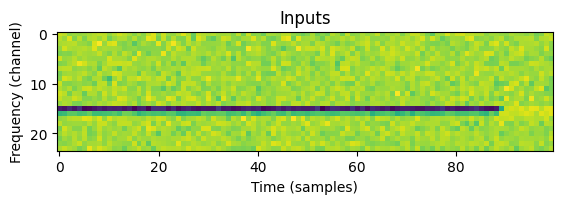

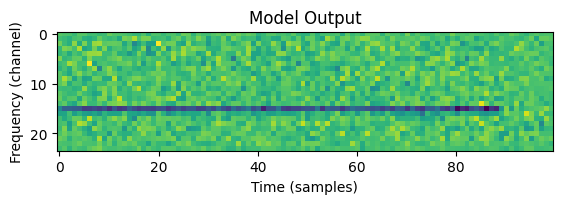

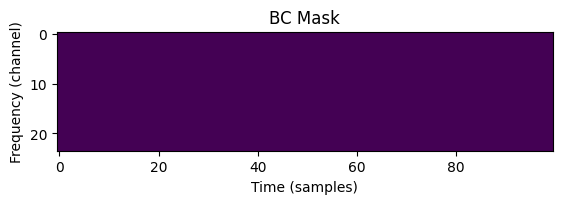

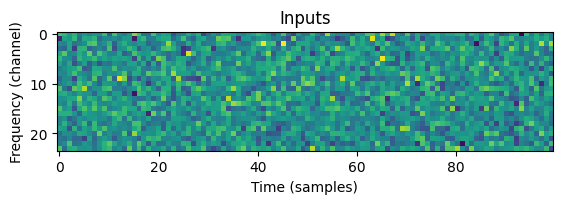

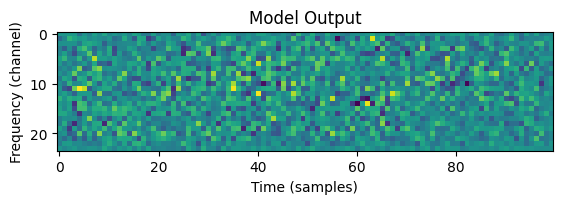

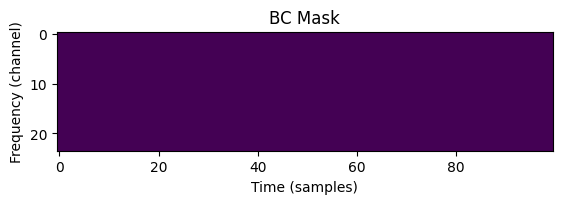

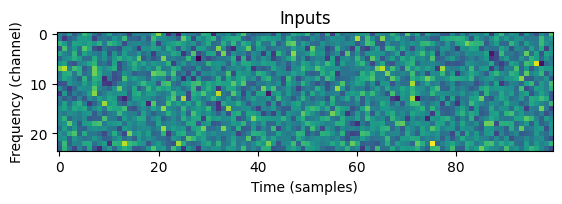

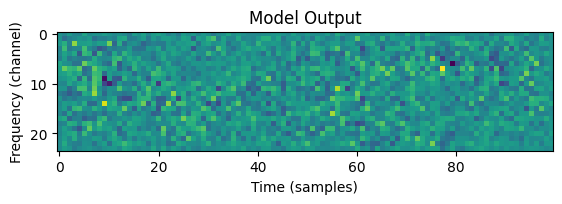

[[ -27.561445  -44.93126   -54.87354  ...  -42.9208    -33.75443
   -17.320532]
 [ -46.616558  -78.89642   -96.843544 ...  -73.41776   -58.75546
   -31.988068]
 [ -54.980232  -93.59512  -116.670204 ...  -81.21011   -65.094376
   -35.91052 ]
 ...
 [ -52.955887  -86.853226 -105.66432  ...  -71.39104   -57.519096
   -31.99783 ]
 [ -41.390045  -68.5841    -83.62168  ...  -55.545     -45.384804
   -25.700792]
 [ -21.236517  -36.643543  -45.99477  ...  -30.713858  -25.481655
   -15.205109]]


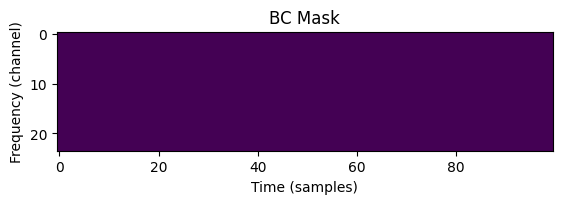

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#@title Vizualize Trained Model


sample_data = c1_train_dataset[:20]
sample_data = (sample_data - np.mean(sample_data)) / np.std(sample_data)

_, sample_loader = load_data(sample_data, np.ones((np.shape(sample_data)[0], 1)), 1)

for x, y in c1_train_loader:
  x, y = x.to(device), y.to(device)
  noise = torch.randn(x.size()).to(device)
  mask = segmentor(x).to(device)
  bc_mask = nn.functional.gumbel_softmax(mask, hard=True, dim=1, tau=1)
  mask = mask[:, 0:1]
  bc_mask = bc_mask[:, 0:1]

  plt.imshow(x.cpu()[1][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Inputs')
  plt.show()

  plt.imshow((mask * noise + (1 - mask) * x).cpu().detach().numpy()[1][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Model Output')
  plt.show()

  plt.imshow(bc_mask.cpu().detach().numpy()[1][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('BC Mask')
  plt.show()

  plt.imshow(x.cpu()[2][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Inputs')
  plt.show()

  plt.imshow((mask * noise + (1 - mask) * x).cpu().detach().numpy()[2][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Model Output')
  plt.show()

  plt.imshow(bc_mask.cpu().detach().numpy()[2][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('BC Mask')
  plt.show()

  plt.imshow(x.cpu()[3][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Inputs')
  plt.show()

  plt.imshow((mask * noise + (1 - mask) * x).cpu().detach().numpy()[3][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Model Output')
  plt.show()
  print(mask.cpu().detach().numpy()[3][0])

  plt.imshow(bc_mask.cpu().detach().numpy()[3][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('BC Mask')
  plt.show()
  print(bc_mask.cpu().detach().numpy()[3][0])

  break
# visualize(segmentor, sample_loader)

In [ ]:
#@title Plotting Loss Curves

def plot_discriminator_loss(losses, title):
  plt.figure()
  plt.plot(losses['epoch'], losses['train_loss'].astype(float))
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.yscale("log")
  plt.show()

def plot_segmentor_loss(losses, title):
  plt.figure()
  plt.plot(losses['epoch'], losses['train_loss'].astype(float))
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.figure()
  plt.plot(losses['epoch'].astype(int), losses['patch_loss'].astype(float), label='Patch Size Loss')
  plt.plot(losses['epoch'].astype(int), losses['category_loss'].astype(float), label='Categorization Loss')
  plt.legend()
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

# for num in range(1, 50, 4):
  # losses = pd.read_csv('/content/drive/MyDrive/CS 101 Group/discriminator/var_loss_discriminator.csv')
  # plot_discriminator_loss(losses, 'Discriminator Loss')
losses = pd.read_csv(f'/content/drive/MyDrive/CS 101 Group/discriminator/last_week_lambda0.25_segmentor.csv')
plot_segmentor_loss(losses[2:], 'Segmentor Loss')
print(losses)

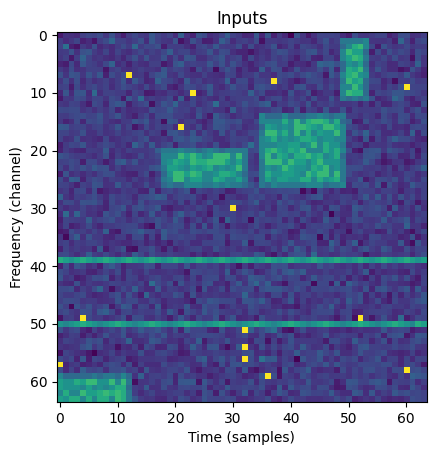

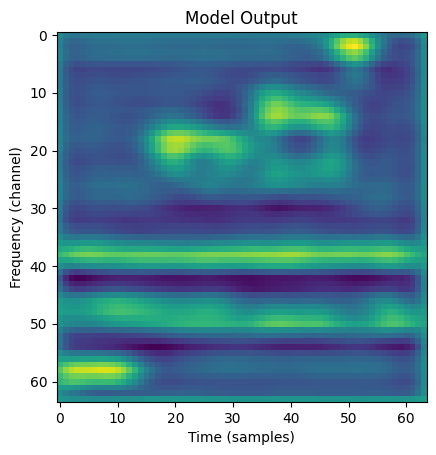

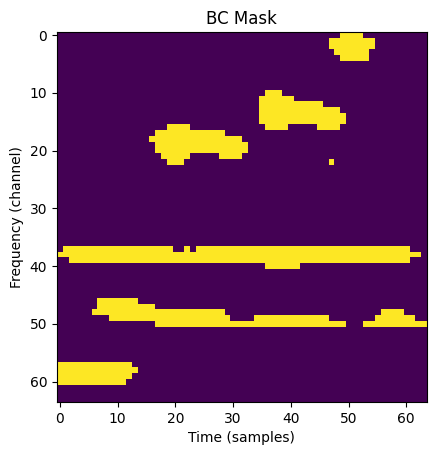

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


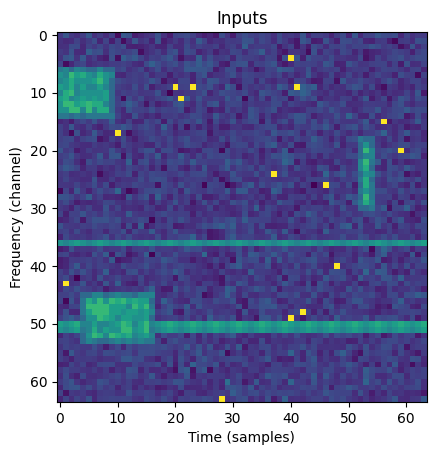

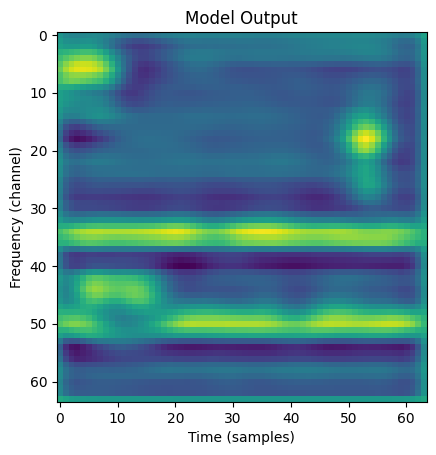

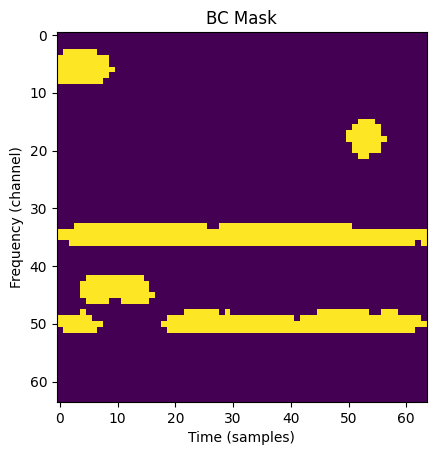

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


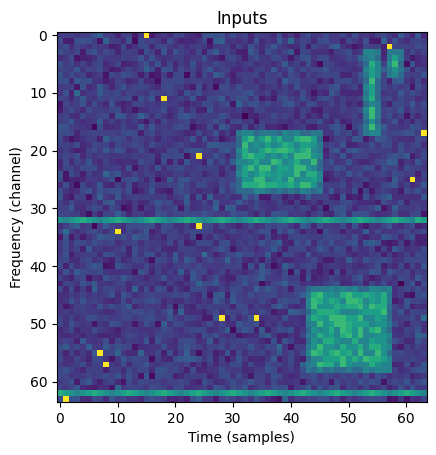

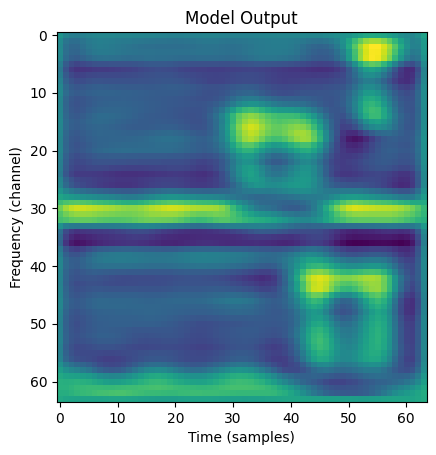

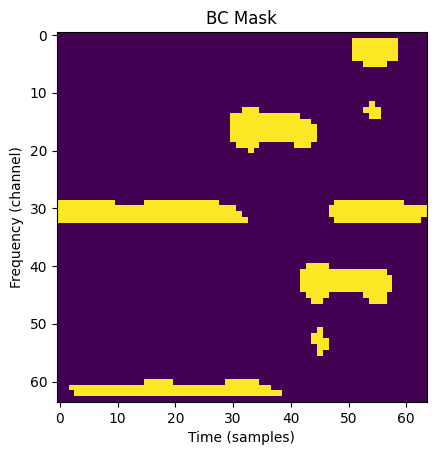

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#@title Initialize Data
batch_size = 128

data = np.load('/content/drive/MyDrive/CS 101 Group/simul_data_with_sources.npy')
labels = np.load('/content/drive/MyDrive/CS 101 Group/simul_labels_with_sources.npy')
size = np.shape(data)[0]

train_dataset = data[:int(size * 0.7)]
train_labels = labels[:int(size * 0.7)]
validation_dataset = data[int(size * 0.7): int(size * 0.85)]
validation_labels = labels[int(size * 0.7): int(size * 0.85)]
test_dataset = data[int(size * 0.85):]
test_labels = labels[int(size * 0.85):]

train_dataset = (train_dataset - np.mean(train_dataset)) / np.std(train_dataset)
validation_dataset = (validation_dataset - np.mean(validation_dataset)) / np.std(validation_dataset)
test_dataset = (test_dataset - np.mean(test_dataset)) / np.std(test_dataset)

_, train_loader = load_data(train_dataset, train_labels, batch_size)
_, validation_loader = load_data(validation_dataset, validation_labels, np.shape(validation_dataset)[0])
_, test_loader = load_data(test_dataset, test_labels, np.shape(test_dataset)[0])

for x, y in train_loader:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  x, y = x.to(device), y.to(device)
  mask = segmentor(x).to(device)
  bc_mask = nn.functional.gumbel_softmax(mask, hard=True, dim=1, tau=1)
  mask = mask[:, 0:1]
  bc_mask = bc_mask[:, 0:1]

  plt.imshow(x.cpu()[10][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Inputs')
  plt.show()

  plt.imshow(mask.cpu().detach().numpy()[10][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Model Output')
  plt.show()

  plt.imshow(bc_mask.cpu().detach().numpy()[10][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('BC Mask')
  plt.show()

  print(bc_mask.cpu().detach().numpy()[10][0])

  plt.imshow(x.cpu()[11][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Inputs')
  plt.show()

  plt.imshow(mask.cpu().detach().numpy()[11][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Model Output')
  plt.show()

  plt.imshow(bc_mask.cpu().detach().numpy()[11][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('BC Mask')
  plt.show()

  print(bc_mask.cpu().detach().numpy()[11][0])

  plt.imshow(x.cpu()[12][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Inputs')
  plt.show()

  plt.imshow(mask.cpu().detach().numpy()[12][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('Model Output')
  plt.show()

  plt.imshow(bc_mask.cpu().detach().numpy()[12][0])
  plt.xlabel('Time (samples)')
  plt.ylabel('Frequency (channel)')
  plt.title('BC Mask')
  plt.show()

  print(bc_mask.cpu().detach().numpy()[12][0])
  break
# visualize(segmentor, sample_loader)

In [ ]:
a = torch.tensor([1., 2., 3.])
b = torch.sqrt(a)
print(b)